## About

Throughout this notebook, I will be working with the famous sleepstudy dataset. I'm going to estimate a hierarchical linear regression with both varying intercepts and varying slopes. The goal is to understand how to place non-independent priors for the group-specific effects in PyMC3 as efficiently as possible.

## Libraries

In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

from formulae import design_matrices

## The data

In [2]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/lme4/sleepstudy.csv",
    index_col = 0
)

In [3]:
data.head()

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308


In [4]:
print(f"Days range from {data['Days'].min()} to {data['Days'].max()}.")
print(f"There are J={data['Subject'].unique().size} subjects.")

Days range from 0 to 9.
There are J=18 subjects.


## The model

I use the greek letter $\beta$ to refer to common effects and the roman letter $u$ to refer to group-specific effects.

$$
y_{ij} = \beta_0 + u_{0j} + \left( \beta_1 + u_{1j} \right) \cdot {\rm{Days}} + \epsilon_i
$$

where

$
y_{ij} = \text{Reaction time for the subject } j \text{ on day } i \\
\beta_0 = \text{Intercept common to all subjects} \\ 
\beta_1 = \text{Days slope common to all subjects} \\
u_{0j} = \text{Intercept specific to the subject } j \\
u_{1j} = \text{Days slope for the subject } j \\
\epsilon_i = \text{Residual random error}
$

Days index go from $i=1$ to $i=10$, and subjects index go from $j=1$ to $j=18$.


## Priors



### Common effects

For the common effects, we Guassian independent priors. 

$$
\begin{array}{c}
\beta_0 \sim \text{Normal}\left(\bar{y}, \sigma_{\beta_0}\right) \\
\beta_1 \sim \text{Normal}\left(0, \sigma_{\beta_1}\right) 
\end{array}
$$

Bambi centers the prior for the intercept at $\bar{y}$, so do we.


### Residual error

$$
\begin{array}{c}
\epsilon_i \sim \text{Normal}(0, \sigma) \\
\sigma \sim \text{HalfStudentT}(\nu, \sigma_\epsilon)
\end{array}
$$

Where $\nu$ and $\sigma_\epsilon$, both positive constants, represent the degrees of freedom and the scale parameter, respectively.

### Group-specific effects


#### Independent priors

$$
\begin{array}{lr}
u_{0j} \sim \text{Normal} \left(0, \sigma_{u_0}\right) & \text{for all } j:1,..., 18 \\
u_{1j} \sim \text{Normal} \left(0, \sigma_{u_1}\right) & \text{for all } j:1,..., J18
\end{array}
$$

where the hyperpriors are 

$$
\begin{array}{c}
\sigma_{u_0} \sim \text{HalfNormal} \left(\tau_0\right) \\
\sigma_{u_1} \sim \text{HalfNormal} \left(\tau_1\right) 
\end{array}
$$

where $\tau_0$ and $\tau_1$ represent the standard deviations of the hyperpriors. These are fixed positive constants.

#### Correlated priors

Instead of placing independent priors on $u_{0j}$ and $u_{1j}$, we place a multivariate normal prior on $[u_{0j}, u_{1j}]^T$, which allows for correlated group-specific effects.

$$
\begin{array}{lr}
    \left[ 
        \begin{array}{c} 
            u_{0j} \\ 
            u_{0j} 
        \end{array}
    \right]
    \sim \text{MvNormal}
    \left(
        \left[ 
            \begin{array}{c} 
                0 \\ 
                0 
            \end{array}
        \right],
        \Sigma = 
        \left[
            \begin{array}{cc}
                \sigma_{u_0}^2 & \text{cov}(u_0, u_1) \\
                \text{cov}(u_0, u_1) & \sigma_{u_1}^2
            \end{array}
        \right]
    \right)
    &
    \text{for all } j:1,..., 18
\end{array}
$$

and we use the same hyperpriors

$$
\begin{array}{c}
\sigma_{u_0} \sim \text{HalfNormal} \left(\tau_0\right) \\
\sigma_{u_1} \sim \text{HalfNormal} \left(\tau_1\right) 
\end{array}
$$


### Correlated priors in practice 

#### Prior on correlation matrices

In practice, we do not set a prior for the covariance matrix $\Sigma$. Instead, we set a prior on the correlation matrix $\Omega$, and use the following decomposition to recover the covariance matrix

$$
\begin{split}
    \Sigma & = 
    \begin{pmatrix}
        \sigma_{u_0} & 0 \\
        0 & \sigma_{u_1}
    \end{pmatrix}
    \begin{pmatrix} 1 & \rho_{u_0, u_1} \\ \rho_{u_0, u_1} & 1 \end{pmatrix} 
    \begin{pmatrix}
        \sigma_{u_0} & 0 \\
        0 & \sigma_{u_1}
    \end{pmatrix} \\
      & = \text{diag}(\sigma_u) \ \Omega \ \text{diag}(\sigma_u) 
\end{split}
$$

We use an LKJ prior for the correlation matrix

$$
\Omega \sim \text{LKJ}(\eta), \ \  \eta > 0
$$

If $\eta = 1$ (our default choice), the prior is jointly uniform over all correlation matrices of the same dimension as $\Omega$. If $\eta > 1$, then the mode of the distribution is the identity matrix. The larger the value of $\eta$ the more sharply peaked the density is at the identity matrix

#### Cholesky decomposition

For efficiency and numerical stability, the correlation matrix $\Omega$ can be parametrized by its (lower-triangular) Cholesky factor $L$, which can be seen as the square root of $\Omega$

$$
\boldsymbol{L}\boldsymbol{L^T} = \Omega = \begin{pmatrix} 1 & \rho_{u_0, u_1} \\ \rho_{u_0, u_1} & 1 \end{pmatrix} 
$$

If $\boldsymbol{Z}_{\text{uncorr}}$ is a $2\times n$ matrix where the rows are 2 samples from uncorrelated random variables, then

$$
\begin{split}
    \boldsymbol{Z}_{\text{corr}} & =
    \begin{pmatrix} \sigma_{u_0} & 0 \\ 0 & \sigma_{u_1} \end{pmatrix} 
    \boldsymbol{L}
    \boldsymbol{Z}_{\text{uncorr}} \\
    & = \text{diag}(\sigma_u) \boldsymbol{L} \boldsymbol{Z}_{\text{uncorr}}     
\end{split}
$$


Then $\boldsymbol{Z}_{\text{corr}}$, of shape $(2, n)$, contains a sample of size $n$ of two correlated variables with the desired variances $\sigma_{u_0}^2$, $\sigma_{u_1}^2$, and correlation $\rho_{u_0, u_1}$.


### Correlated priors in PyMC3

The $\text{MvNormal}$ distribution takes a vector of means and a covariance matrix as input. A naive approach to obtain samples from this distribution in PyMC3 would be to do 

```python
b = pm.MvNormal("b", mu=np.zeros(2), cov=Σ, dims=dims) 
```

But using the Cholesky decomposition we can obtain the same result, much more efficiently. The function `pm.LKJCholeskyCov` provides us with the Cholesky decomposition of the covariance matrix. Note it says **covariance** and not correlation. This means we get the result of $\text{diag}(\sigma_u) \boldsymbol{L}$, not just $\boldsymbol{L}$.


```python
# Only a sketch, the code that works is provided below
L_u = pm.LKJCholeskyCov("L_u", ...)
b_raw = pm.Normal('b_raw', mu=0, sigma=1, ...) 
b = pm.Deterministic('b', tt.dot(L_u, b_raw).T)
```

As a side note, we mention that `pm.MvNormal` also has a `chol` argument where we can pass the result of `pm.LKJCholeskyCov`. But this is not a good idea. The sampler takes much longer.

## Models

## Model 1: Bambi

For the moment Bambi only allows independent priors on the terms in a model. The following Bambi model is used as a benchmark in terms of efficiency and posterior distribution.

In [5]:
bmb_model = bmb.Model("Reaction ~ Days + (Days|Subject)", data)
bmb_model

Formula: Reaction ~ Days + (Days|Subject)
Family name: Gaussian
Link: identity
Observations: 180
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 298.5079, sigma: 261.0092)
    Days ~ Normal(mu: 0.0, sigma: 48.8915)

  Group-level effects
    1|Subject ~ Normal(mu: 0, sigma: HalfNormal(sigma: 261.0092))
    Days|Subject ~ Normal(mu: 0, sigma: HalfNormal(sigma: 48.8915))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 56.1721)

In [6]:
bmb_idata = bmb_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Reaction_sigma, Days|Subject_offset, Days|Subject_sigma, 1|Subject_offset, 1|Subject_sigma, Days, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


## Model 2: Independent priors with PyMC3

First, we obtain the design matrix for the common part in the model, $X$. We will be using a matrix multiplication, $X\beta$ to obtain the contribution to the linear predictor from the common effects. 

A different approach is taken for the group-specific effects to avoid large matrix multiplications (although not so large in this case).

In [7]:
dm = design_matrices("Reaction ~ Days + (Days|Subject)", data)
X = dm.common.design_matrix

Then we create a `subject` array with that will represent each of the subjects. These are used with the distribution of the group-specific coefficients.

In [8]:
# Subject index
# It goes from 0 to 17 because Python is 0 indexed
subject = pd.Categorical(data["Subject"]).codes 

And finally the `coords` that we pass to the model and the mean of the prior for the intercept

In [9]:
# Coordinates to handle dimensions of PyMC3 distributions and use better labels
coords = {"subject": data["Subject"].unique(), "effect": ["intercept", "slope"]}

# Response mean -- Used in the prior for the intercept
y_mean = data["Reaction"].mean()

In [10]:
with pm.Model(coords=coords) as model_independent:
    # Common effects
    β0 = pm.Normal("β0", mu=y_mean, sigma=84)
    β1 = pm.Normal("β1", mu=0, sigma=14)
    β = tt.stack(β0, β1)
    
    # Group-specific effects
    # Intercept
    σ_u0 = pm.HalfNormal("σ_u0", sigma=48)
    u0_offset = pm.Normal("u0_offset", mu=0, sigma=1, dims="subject")
    u0 = pm.Deterministic("u0", u0_offset * σ_u0, dims="subject")
    
    # Slope
    σ_u1 = pm.HalfNormal("σ_u1", sigma=14)
    u1_offset = pm.Normal("u1_offset", mu=0, sigma=1, dims="subject")
    u1 = pm.Deterministic("u1", u1_offset * σ_u1, dims="subject")
    
    # Conditional mean    
    μ = pm.math.dot(X, β) + u0[subject] * X[:, 0] + u1[subject] * X[:, 1]
    
    # Residual standard deviation
    σ = pm.HalfStudentT("σ", nu=4, sigma=56)
    
    # Response
    y = pm.Normal('y', mu=μ, sigma=σ, observed=data["Reaction"])
    idata_independent = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, u1_offset, σ_u1, u0_offset, σ_u0, β1, β0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


## Model 3: Correlated priors with PyMC3

Here we use `pm.LKJCholeskyCov`. `n` represents the dimension of the correlation matrix. `eta` is the parameter of the `LKJCorr` distribution. `sd_dist` is the prior distribution for the standard deviations of the group-specific effects. `compute_corr=True` means we want it to also return the correlation between the group-specific parameters and their standard deviatios. `store_in_trace` means we don't want to store the correlation and the standard deviations in the trace.

Before seeing the code, we note that `sd_dist` is not a random variable, but a stateless distribution (i.e. the result of `pm.Distribution.dist()`).

One problem with `sd_dist` having to be a stateless distribution is that we cannot use a customized distribution for the standard deviations of the group-specific effects... and here introduce rstanarm example.

In [11]:
with pm.Model(coords=coords) as model_correlated:
    ## Common effects
    β0 = pm.Normal("β0", mu=y_mean, sigma=84)
    β1 = pm.Normal("β1", mu=0, sigma=14)
    β = tt.stack(β0, β1)
    
    ## Group-specific effects
    # Hyper prior for the standard deviations
    u_σ = pm.HalfNormal.dist(sigma=np.array([48, 14]), shape=2)
    
    # Obtain Cholesky factor for the covariance
    L, ρ_u, σ_u = pm.LKJCholeskyCov("L", n=2, eta=1, sd_dist=u_σ, compute_corr=True, store_in_trace=False)
    
    # Parameters
    u_raw = pm.Normal("u_raw", mu=0, sigma=1, dims=("effect", "subject")) 
    u = tt.dot(L, u_raw).T
   
    ## Separate group-specific terms 
    # Intercept
    u0 = pm.Deterministic("u0", u[:, 0], dims="subject")
    σ_u0 = pm.Deterministic("σ_u0", σ_u[0])
    
    # Slope
    u1 = pm.Deterministic("u1", u[:, 1], dims="subject")
    σ_u1 = pm.Deterministic("σ_u1", σ_u[1])
    
    # Correlation
    ρ_u = pm.Deterministic("ρ_u", ρ_u[0, 1])
    
    ## Conditional mean  
    μ = pm.math.dot(X, β) + u0[subject] * X[:, 0] + u1[subject] * X[:, 1]
    
    ## Residual standard deviation
    σ = pm.HalfStudentT("σ", nu=4, sigma=56)
    
    ## Response
    y = pm.Normal("y", mu=μ, sigma=σ, observed=data.Reaction)
    
    idata_correlated = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, u_raw, L, β1, β0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.


We also clean up the resulting InferenceData

In [12]:
idata_correlated.posterior = idata_correlated.posterior.drop_vars(["L", "u_raw"])
idata_correlated.posterior = idata_correlated.posterior.drop_dims("L_dim_0")
idata_correlated.posterior = idata_correlated.posterior.transpose("chain", "draw", "effect", "subject")

## Plot posteriors

Rename Bambi's InferenceData object to match the ones from PyMC3

In [13]:
bmb_idata.rename({
    "Intercept": "β0", 
    "Days": "β1", 
    "Reaction_sigma": "σ", 
    "1|Subject": "u0", 
    "Days|Subject": "u1",
    "1|Subject_sigma": "σ_u0", 
    "Days|Subject_sigma": "σ_u1",
}, inplace=True)

Now use `az.plot_forest()` to compare the posteriors marginal posteriors obtained with the three models

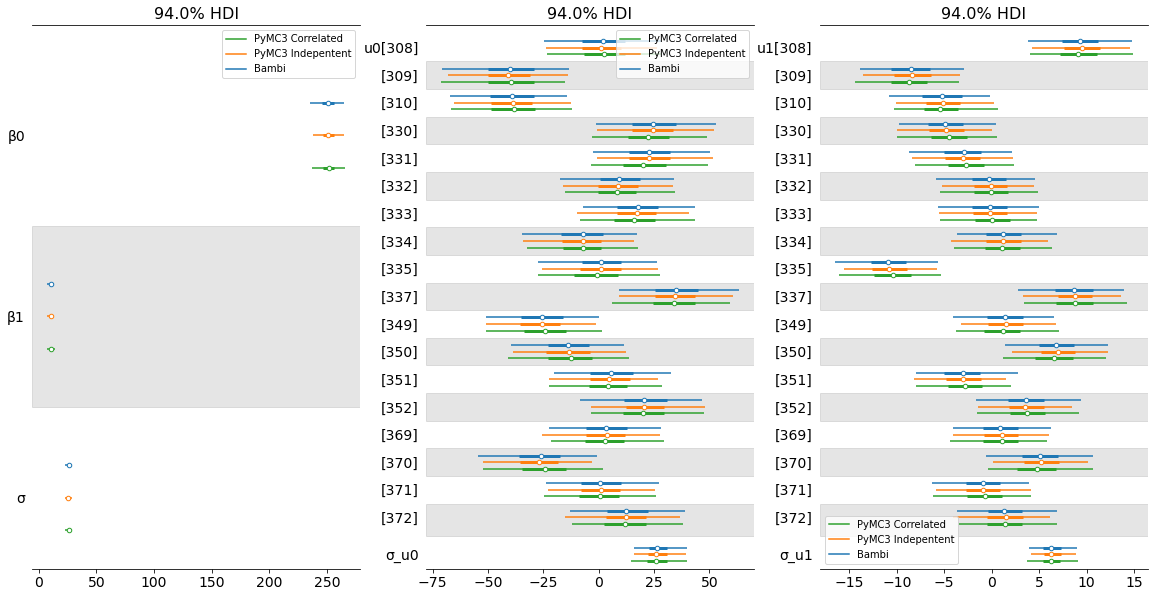

In [14]:
groups = [
    ["β0", "β1", "σ"],
    ["u0", "σ_u0"],
    ["u1", "σ_u1"],
]

model_names = ["Bambi", "PyMC3 Indepentent", "PyMC3 Correlated"]
fig, ax = plt.subplots(1, 3, figsize = (20, 10))

for idx, group in enumerate(groups):
    az.plot_forest(
        [bmb_idata, idata_independent, idata_correlated],
        model_names=model_names,
        var_names=group,
        combined=True,
        ax=ax[idx],
    )

The marginal posteriors for the three different approaches to the hierarchical model described in the beginning of this notebook are the same.

## Other models

The following models are a subset of models I've been written when trying to figure out what's the best approach to use correlated priors for group specific effects in PyMC3.

### Independent priors using matrix multiplication

In this case I take the design matrices for the group-specific effects and use the dot product between these matrices and the vectors of coefficients. While this approach was clearer to me in the beginning, I noticed it is slightly slower than the approach used in the models above (i.e. slicing and multiplying 1d arrays), specially when $Z$ is gets bigger.

In [15]:
dm = design_matrices("Reaction ~ Days + (Days|Subject)", data)
X = dm.common.design_matrix
Z0 = dm.group["1|Subject"]
Z1 = dm.group["Days|Subject"]

with pm.Model(coords=coords) as model:
    β0 = pm.Normal("β0", mu=y_mean, sigma=84)
    β1 = pm.Normal("β1", mu=0, sigma=14)
    β = tt.stack(β0, β1)
    
    σ_u0 = pm.HalfNormal("σ_u0", sigma=48)
    u0_offset = pm.Normal("u0_offset", mu=0, sigma=1, dims="subject")
    u0 = pm.Deterministic("u0", u0_offset * σ_u0, dims="subject")
    
    σ_u1 = pm.HalfNormal("σ_u1", sigma=14)
    u1_offset = pm.Normal("u1_offset", mu=0, sigma=1, dims="subject")
    u1 = pm.Deterministic("u1", u1_offset * σ_u1, dims="subject")
    
    # Note 
    μ = pm.math.dot(X, β) + pm.math.dot(Z0, u0) + pm.math.dot(Z1, u1)
    
    σ = pm.HalfStudentT("σ", nu=4, sigma=56)
    y = pm.Normal("y", mu=μ, sigma=σ, observed=data.Reaction)
    
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, u1_offset, σ_u1, u0_offset, σ_u0, β1, β0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


### Correlated priors without cholesky decomposition

If I want to use a random variable instead of a stateless distribution for the standard deviation of the group-specific effects, then I need to perform many steps manually. 

In [16]:
with pm.Model(coords=coords) as model:
    # Common part
    β0 = pm.Normal("β0", mu=y_mean, sigma=84)
    β1 = pm.Normal("β1", mu=0, sigma=14)
    β = tt.stack(β0, β1)
    
    # Group-specific part   
    σ_u = pm.HalfNormal("u_σ", sigma=np.array([48, 14]), shape=2)
    
    # Triangular upper part of the correlation matrix
    C_triu = pm.LKJCorr("C_triu", eta=1, n=2)

    # Construct correlation matrix
    C = pm.Deterministic("C", tt.fill_diagonal(C_triu[np.zeros((2, 2), dtype=np.int64)], 1.))
    
    # Construct diagonal matrix of standard deviation
    σ_diagonal = pm.Deterministic('σ_diagonal', tt.nlinalg.diag(σ_u))
    
    # Compute covariance matrix
    Σ = tt.nlinalg.matrix_dot(σ_diagonal, C, σ_diagonal)
    
    # Cholesky decomposition of covariance matrix
    L = pm.Deterministic("L", tt.slinalg.cholesky(Σ))
    
    # And finally get group-specific coefficients as in Model 3
    u_raw = pm.Normal("u_raw", mu=0, sigma=1, dims=("effect", "subject")) 
    u = tt.dot(L, u_raw).T

    u0 = pm.Deterministic("u0", u[:, 0], dims="subject")
    σ_u0 = pm.Deterministic("σ_u0", σ_u[0])
    
    u1 = pm.Deterministic("u1", u[:, 1], dims="subject")
    σ_u1 = pm.Deterministic("σ_u1", σ_u[1])
        
    μ = pm.math.dot(X, β) + u0[subject] * X[:, 0] + u1[subject] * X[:, 1]
    
    σ = pm.HalfStudentT("σ", nu=4, sigma=56)
    y = pm.Normal("y", mu=μ, sigma=σ, observed=data.Reaction)
    
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, u_raw, C_triu, u_σ, β1, β0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


### Attempt to replicate rstanarm prior

This model is like the previous one, but `σ_u` is the result of multiplying several random variables. Rstanarm prior is introduced [here](http://mc-stan.org/rstanarm/articles/glmer.html)

In [17]:
J = 2 # Order of covariance matrix

with pm.Model(coords=coords) as model:
    
    # Common part
    β0 = pm.Normal("β0", mu=y_mean, sigma=84)
    β1 = pm.Normal("β1", mu=0, sigma=14)
    β = tt.stack(β0, β1)
    
    # Residual SD 
    σ = pm.HalfStudentT("σ", nu=4, sigma=56)
    
    # Group-specific part
    # Begin of rstanarm approach ----------------------------------
    τ = pm.Gamma("τ", alpha=1, beta=1)
    Σ_trace = J * τ ** 2
    π = pm.Dirichlet("π", a=np.ones(J), shape=J)
    σ_u = pm.Deterministic("b_σ", σ * π * (Σ_trace) ** 0.5)
    # End of rstanarm approach ------------------------------------

    # Triangular upper part of the correlation matrix
    C_triu = pm.LKJCorr("C_triu", eta=1, n=2)
     
    # Correlation matrix
    C = pm.Deterministic("C", tt.fill_diagonal(C_triu[np.zeros((2, 2), dtype=np.int64)], 1.))
    
    σ_u_diagonal = pm.Deterministic('σ_u_diagonal', tt.nlinalg.diag(σ_u))
    
    # Covariance matrix
    Σ = tt.nlinalg.matrix_dot(σ_u_diagonal, C, σ_u_diagonal)
    
    # Cholesky decomposition, lower triangular matrix.
    L = pm.Deterministic("L", tt.slinalg.cholesky(Σ))
    
    u_raw = pm.Normal("u_raw", mu=0, sigma=1, dims=("effect", "subject")) 
    u = tt.dot(L, u_raw).T

    u0 = pm.Deterministic("u0", u[:, 0], dims="subject")
    σ_u0 = pm.Deterministic("σ_u0", σ_u[0])
    
    u1 = pm.Deterministic("u1", u[:, 1], dims="subject")
    σ_u1 = pm.Deterministic("σ_u1", σ_u[1])
    
    # Conditional mean
    μ = pm.math.dot(X, β) + u0[subject] * X[:, 0] + u1[subject] * X[:, 1]
    
    y = pm.Normal("y", mu=μ, sigma=σ, observed=data.Reaction)

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [u_raw, C_triu, π, τ, σ, β1, β0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.


/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tomas/

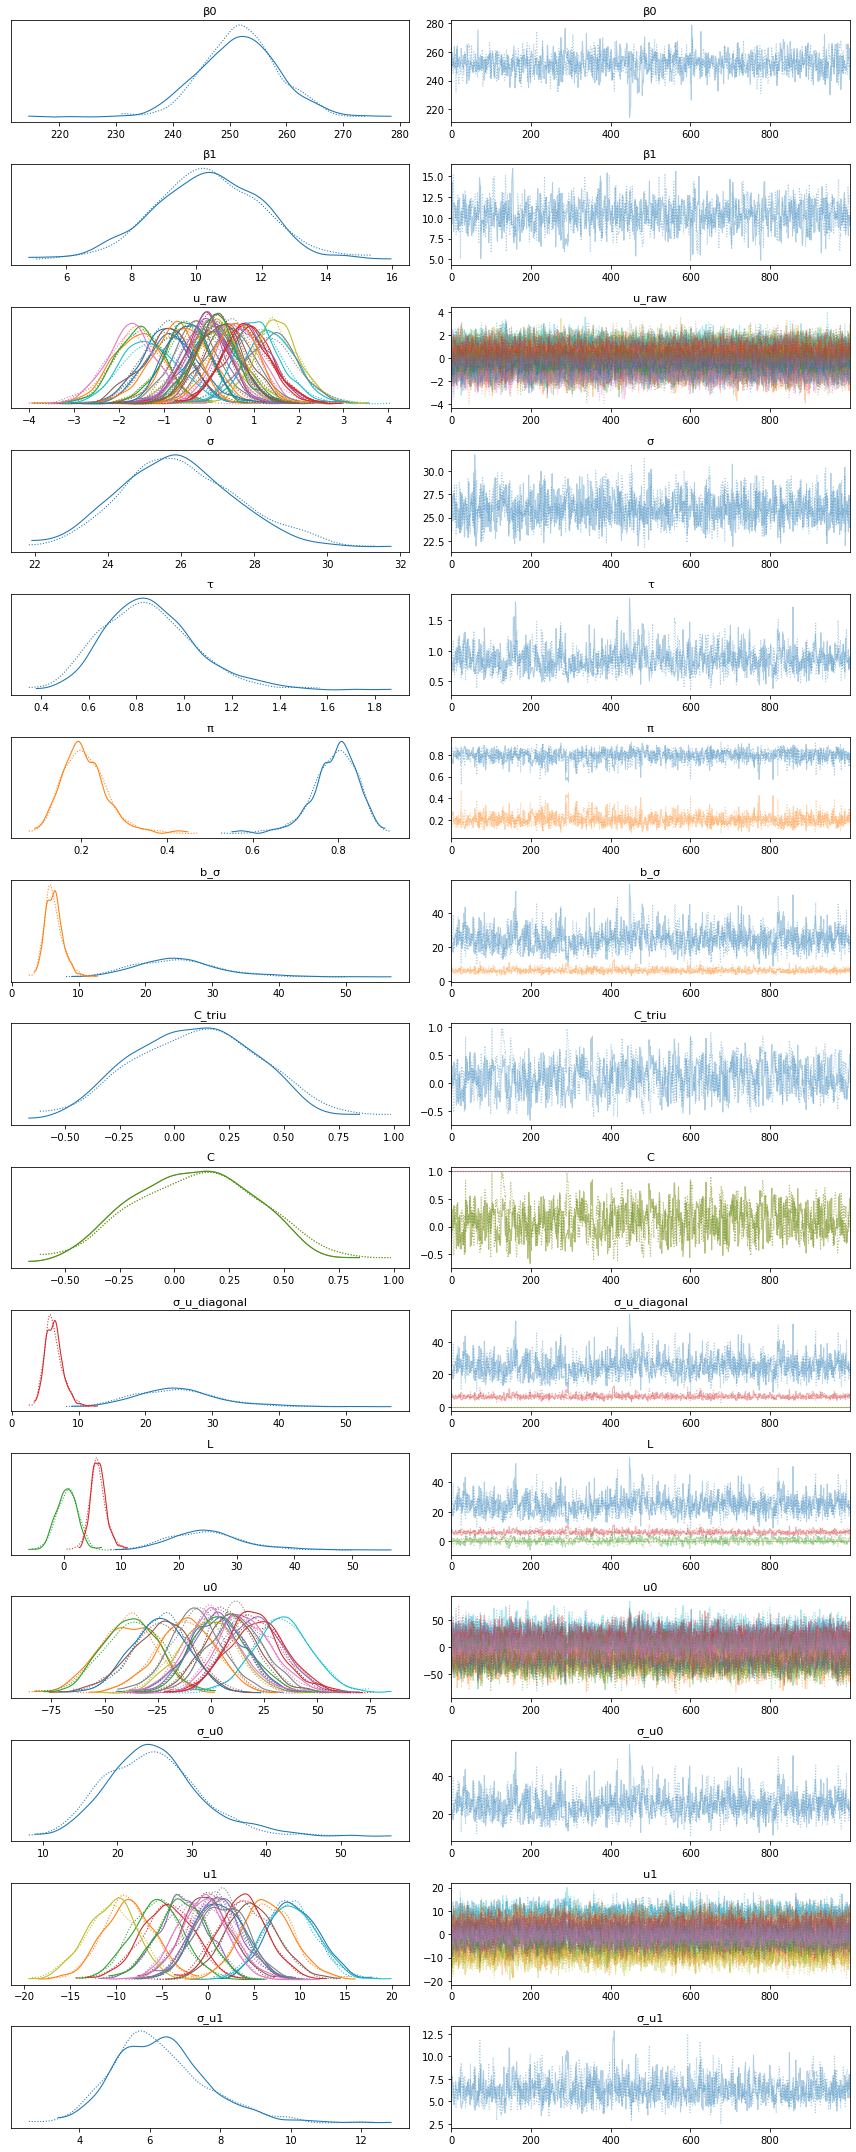

In [20]:
az.plot_trace(idata)
plt.tight_layout()

## Conclusions

* We showed how to use correlated priors for group-specific coefficients.
* The posteriors resulted to be the same for the three models compared above.
* The correlated priors didn't imply any benefit to our sampling process. However, this could be beneficial for more complex hierarchical models. 
* What's more, the model with the correlated priors took almost twice as long as the one with independent priors.
* Attempting to replicate rstanarm approach takes even longer (same model with rstanarm takes ~ 20 secs) because we are forced to compute many things manually.

Final notes/suggestions

* Sometimes, the models with correlated priors based on `pm.LKJCorr` resulted in divergences.
* It would be good to be able to pass a random variable to `sd_dist` in `pm.LKJCholeskyCov`, and not just a stateless distribution. This forced me to use `pm.LKJCorr` and perform many manipulations manually, which was more error-prone and inefficient.
* It's better to avoid matrix multiplications when adding group-specific effects. Matrices were not huge here, but the difference when these matrices are bigger.
* It would be good to check if there's something in the LKJCorr/LKJCholeskyCov that could be improved. I plan to use `LKJCholeskyCov` within Bambi in the future and I would like it to work as better as possible.

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jan 16 2022

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.29.0

pymc3     : 3.11.4
pandas    : 1.3.1
arviz     : 0.11.4
theano    : 1.1.2
numpy     : 1.21.2
matplotlib: 3.4.3
sys       : 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
bambi     : 0.7.1

Watermark: 2.1.0

